
# Udacity Self-Driving — Starter Notebook (Behavioral Cloning)
**What this notebook does (step-wise):**
1. Load `driving_log.csv` and images (center/left/right).  
2. Visualize sample rows & images.  
3. Preprocess images (crop, resize, normalize).  
4. Apply augmentations (flip, brightness, translation).  
5. Create a Python generator for efficient training.  
6. Build the NVIDIA CNN (end-to-end steering prediction).  
7. Train a baseline model (example config).  
8. Save the model for simulator / real-vehicle fine-tuning.

> **Files expected (already present):**
- `/mnt/data/driving_log.csv`  
- image files (e.g., `center_2025_08_27_23_00_47_235.jpg`, `left_*.jpg`, `right_*.jpg`) in `/mnt/data/`

**Notes:** This notebook is written so you can run it locally in a virtualenv. If TensorFlow / OpenCV are not installed in your environment, install them first (`pip install -r requirements.txt`).  


In [12]:
# Imports & configuration
import os
import math
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# The heavy libraries (cv2, tensorflow) are imported later inside functions so the notebook
# starts even if they are not installed. When you run training cells, make sure dependencies exist.

# Instead of single DATA_DIR, keep a list of all session folders
LOG_DIRS = [
    "./session1",   # update paths according to your data
    "./session2"
]

print("Expected driving logs in these folders:")
for d in LOG_DIRS:
    print(" -", d)
    if os.path.exists(d):
        files = os.listdir(d)
        print("   contains:", files[:10])


Expected driving logs in these folders:
 - ./session1
   contains: ['driving_log.csv', 'IMG']
 - ./session2
   contains: ['driving_log.csv', 'IMG']


In [13]:
# 1) Load driving_log.csv from multiple log directories
import csv

dfs = []

for log_dir in LOG_DIRS:
    csv_path = os.path.join(log_dir, "driving_log.csv")
    if not os.path.exists(csv_path):
        print(f"Skipping, no CSV found: {csv_path}")
        continue

    # Detect separator
    with open(csv_path, 'r', encoding='utf-8', errors='ignore') as f:
        sample = f.read(2048)
        if '\t' in sample:
            sep = '\t'
        elif ';' in sample and ',' not in sample:
            sep = ';'
        else:
            sep = ','

    print(f"Detected CSV separator for {csv_path}:", repr(sep))
    df = pd.read_csv(csv_path, sep=sep, header=None, engine='python', na_filter=False)

    # Standardize column names
    if df.shape[1] >= 7:
        df = df.iloc[:, :7]
        df.columns = ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
    else:
        df.columns = [f'col{i}' for i in range(df.shape[1])]

    # Store IMG dir path in a new column (will use later to fix image paths)
    df["img_dir"] = os.path.join(log_dir, "IMG")

    dfs.append(df)

# Combine all logs into one DataFrame
if not dfs:
    raise FileNotFoundError("No driving_log.csv found in provided LOG_DIRS")

df_all = pd.concat(dfs, ignore_index=True)

print("Combined CSV shape:", df_all.shape)
df_all.head(5)


Detected CSV separator for ./session1\driving_log.csv: ','
Detected CSV separator for ./session2\driving_log.csv: ','
Combined CSV shape: (1881, 8)


,center,left,right,steering,throttle,brake,speed,img_dir
0,C:\Users\nages\Downloads\simulator-windows-64\...,C:\Users\nages\Downloads\simulator-windows-64...,C:\Users\nages\Downloads\simulator-windows-64...,0.0,0.0,0.0,0.000078,./session1\IMG
1,C:\Users\nages\Downloads\simulator-windows-64\...,C:\Users\nages\Downloads\simulator-windows-64...,C:\Users\nages\Downloads\simulator-windows-64...,0.0,0.0,0.0,0.000078,./session1\IMG
2,C:\Users\nages\Downloads\simulator-windows-64\...,C:\Users\nages\Downloads\simulator-windows-64...,C:\Users\nages\Downloads\simulator-windows-64...,0.0,0.0,0.0,0.000078,./session1\IMG
3,C:\Users\nages\Downloads\simulator-windows-64\...,C:\Users\nages\Downloads\simulator-windows-64...,C:\Users\nages\Downloads\simulator-windows-64...,0.0,0.0,0.0,0.000080,./session1\IMG
4,C:\Users\nages\Downloads\simulator-windows-64\...,C:\Users\nages\Downloads\simulator-windows-64...,C:\Users\nages\Downloads\simulator-windows-64...,0.0,0.0,0.0,0.000079,./session1\IMG


In [14]:
import os

# Helper: normalize image path using each row's img_dir
def img_path_from_csv(path, img_dir):
    # CSV might store full path or just filename. Use basename and join with IMG folder of that log
    base = os.path.basename(str(path).strip())
    return os.path.join(img_dir, base)

# Fix image paths for each center/left/right column
for col in ['center', 'left', 'right']:
    if col in df_all.columns:
        df_all[col] = df_all.apply(lambda row: img_path_from_csv(row[col], row["img_dir"]), axis=1)

# Show sample rows
print("Total combined rows:", len(df_all))
display(df_all.head(6))


Total combined rows: 1881


,center,left,right,steering,throttle,brake,speed,img_dir
0,./session1\IMG\center_2025_08_27_23_03_56_127.jpg,./session1\IMG\left_2025_08_27_23_03_56_127.jpg,./session1\IMG\right_2025_08_27_23_03_56_127.jpg,0.0,0.0,0.0,0.000078,./session1\IMG
1,./session1\IMG\center_2025_08_27_23_03_56_231.jpg,./session1\IMG\left_2025_08_27_23_03_56_231.jpg,./session1\IMG\right_2025_08_27_23_03_56_231.jpg,0.0,0.0,0.0,0.000078,./session1\IMG
2,./session1\IMG\center_2025_08_27_23_03_56_339.jpg,./session1\IMG\left_2025_08_27_23_03_56_339.jpg,./session1\IMG\right_2025_08_27_23_03_56_339.jpg,0.0,0.0,0.0,0.000078,./session1\IMG
3,./session1\IMG\center_2025_08_27_23_03_56_442.jpg,./session1\IMG\left_2025_08_27_23_03_56_442.jpg,./session1\IMG\right_2025_08_27_23_03_56_442.jpg,0.0,0.0,0.0,0.000080,./session1\IMG
4,./session1\IMG\center_2025_08_27_23_03_56_551.jpg,./session1\IMG\left_2025_08_27_23_03_56_551.jpg,./session1\IMG\right_2025_08_27_23_03_56_551.jpg,0.0,0.0,0.0,0.000079,./session1\IMG
5,./session1\IMG\center_2025_08_27_23_03_56_662.jpg,./session1\IMG\left_2025_08_27_23_03_56_662.jpg,./session1\IMG\right_2025_08_27_23_03_56_662.jpg,0.0,0.0,0.0,0.000078,./session1\IMG


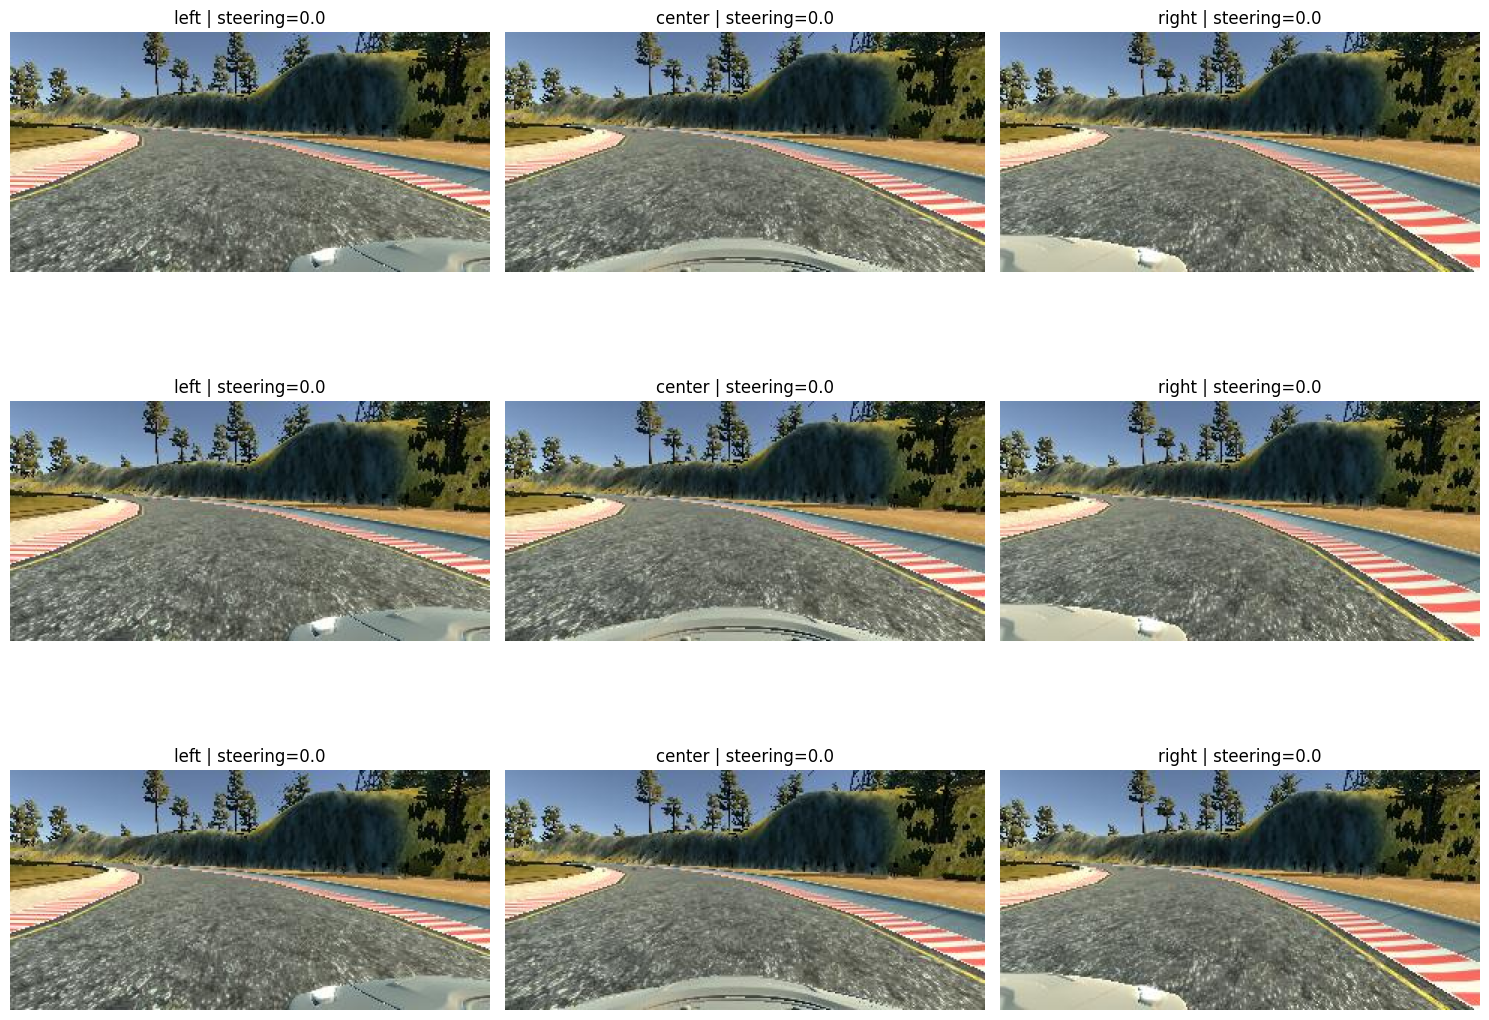

In [15]:
# Visualize some sample images (center, left, right)
import cv2

def show_image(path, ax=None, title=None):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if ax is None:
        plt.figure(figsize=(8,3))
        plt.imshow(img); plt.axis('off')
        if title: plt.title(title)
    else:
        ax.imshow(img); ax.axis('off')
        if title: ax.set_title(title)

# Display first N samples
N = min(3, len(df_all))
plt.figure(figsize=(15, 4*N))
for i in range(N):
    row = df_all.iloc[i]
    ax = plt.subplot(N, 3, i*3 + 1)
    try:
        show_image(row['left'], ax=ax, title=f"left | steering={row.get('steering','?')}")
    except Exception as e:
        ax.text(0.5,0.5,str(e)); ax.axis('off')
    ax = plt.subplot(N, 3, i*3 + 2)
    try:
        show_image(row['center'], ax=ax, title=f"center | steering={row.get('steering','?')}")
    except Exception as e:
        ax.text(0.5,0.5,str(e)); ax.axis('off')
    ax = plt.subplot(N, 3, i*3 + 3)
    try:
        show_image(row['right'], ax=ax, title=f"right | steering={row.get('steering','?')}")
    except Exception as e:
        ax.text(0.5,0.5,str(e)); ax.axis('off')
plt.tight_layout()


In [16]:
# Preprocessing: crop, resize, normalize
# We'll use the Nvidia input size: 66 x 200 (HxW)
def preprocess_image(cv2_img, resize=(200,66)):
    # cv2_img: color image in BGR (as returned by cv2.imread)
    import cv2
    # convert to RGB
    img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    # crop: remove sky and hood roughly (tweak based on images)
    top = int(h*0.35)   # remove top 35%
    bottom = int(h*0.1) # remove bottom 10%
    img = img[top:h-bottom, :, :]
    # resize (width, height)
    img = cv2.resize(img, resize, interpolation=cv2.INTER_AREA)
    # normalize to range [-0.5, 0.5]
    img = img.astype('float32') / 255.0 - 0.5
    return img

# Quick test (only if cv2 is present)
try:
    import cv2
    sample_img = cv2.imread(df_all['center'].iloc[0])
    if sample_img is not None:
        pre = preprocess_image(sample_img)
        print("Preprocessed image shape:", pre.shape, "min/max:", pre.min(), pre.max())
    else:
        print("Couldn't read sample image for preprocessing test.")
except Exception as e:
    print("cv2 not available or preprocess test failed:", e)


Preprocessed image shape: (66, 200, 3) min/max: -0.5 0.5


In [17]:
import numpy as np
import random
import cv2

def random_flip(image, steering):
    # image: RGB float image in range [-0.5, 0.5]
    if random.random() < 0.5:
        image = np.fliplr(image)
        steering = -steering
    return image, steering

def random_brightness(image):
    # expects RGB float [-0.5, 0.5]; convert to 0..1 first
    img = image + 0.5
    hsv = cv2.cvtColor((img*255).astype('uint8'), cv2.COLOR_RGB2HSV)
    factor = 0.4 + np.random.uniform()  # brightness factor [0.4, 1.4]
    hsv[:,:,2] = np.clip(hsv[:,:,2].astype(float) * factor, 0, 255).astype('uint8')
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB).astype('float32') / 255.0 - 0.5
    return img

def random_translate(image, steering, range_x=50, range_y=10):
    # translate image and adjust steering slightly
    rows, cols = image.shape[:2]
    tr_x = range_x * (np.random.uniform() - 0.5)
    tr_y = range_y * (np.random.uniform() - 0.5)
    M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    
    trans = cv2.warpAffine(((image+0.5)*255.0).astype('uint8'), M, (cols, rows))
    trans = trans.astype('float32')/255.0 - 0.5  # back to [-0.5, 0.5]
    
    steering += tr_x * 0.002  # tuning factor
    return trans, steering


In [18]:
def generator(samples, batch_size=32, is_training=True, correction=0.2):
    num_samples = len(samples)
    while True:
        # shuffle each epoch
        samples = samples.sample(frac=1).reset_index(drop=True) if is_training else samples
        
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples.iloc[offset:offset+batch_size]
            images = []
            steerings = []
            
            for _, row in batch_samples.iterrows():
                # pick center/left/right
                choice = random.choice(['center','left','right']) if is_training else 'center'
                img_path = row[choice]
                steering = float(row.get('steering', 0.0))
                
                # adjust for left/right
                if choice == 'left':
                    steering += correction
                elif choice == 'right':
                    steering -= correction
                
                img = cv2.imread(img_path)  # BGR
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                # --- augment before preprocessing ---
                if is_training:
                    img, steering = random_flip(img, steering)
                    img = random_brightness(img)
                    img, steering = random_translate(img, steering)
                
                # preprocess (crop, resize, normalize)
                img = preprocess_image(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
                
                images.append(img)
                steerings.append(steering)
            
            if len(images) > 0:
                yield np.array(images), np.array(steerings)


In [19]:
def build_nvidia_model(input_shape=(66,200,3)):
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Lambda

    model = Sequential()
    # Normalization (optional: already done in preprocess)
    model.add(Lambda(lambda x: x, input_shape=input_shape))
    
    # NVIDIA architecture
    model.add(Conv2D(24, (5,5), strides=(2,2), activation='relu'))
    model.add(Conv2D(36, (5,5), strides=(2,2), activation='relu'))
    model.add(Conv2D(48, (5,5), strides=(2,2), activation='relu'))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(Conv2D(64, (3,3), activation='relu'))
    
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))   # regression output (steering)
    
    return model


Train samples: 852 Validation samples: 213
🚀 Starting training... Steps per epoch: 26


C:\Users\nages\AutonomousEV\venv\lib\site-packages\keras\src\layers\core\lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0641
Epoch 1: val_loss improved from None to 0.05070, saving model to model_best.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - loss: 0.0647 - val_loss: 0.0507
Epoch 2/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0566
Epoch 2: val_loss did not improve from 0.05070
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.0545 - val_loss: 0.0522
Epoch 3/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0632
Epoch 3: val_loss improved from 0.05070 to 0.04626, saving model to model_best.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0582 - val_loss: 0.0463
Epoch 4/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0690
Epoch 4: val_loss improved from 0.04626 to 0.04597, saving model to model_best.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0620 - val_loss: 0.0460
Epoch 5/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0502
Epoch 5: val_loss did not improve from 0.04597
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0623 - val_loss: 0.0489
Epoch 6/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0549
Epoch 6: val_loss did not improve from 0.04597
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0563 - val_loss: 0.0479
Epoch 7/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0664
Epoch 7: val_loss did not improve from 0.04597
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0563 - val_loss: 0.0535
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.


Model training complete. Saved final model to: .\model_final.h5


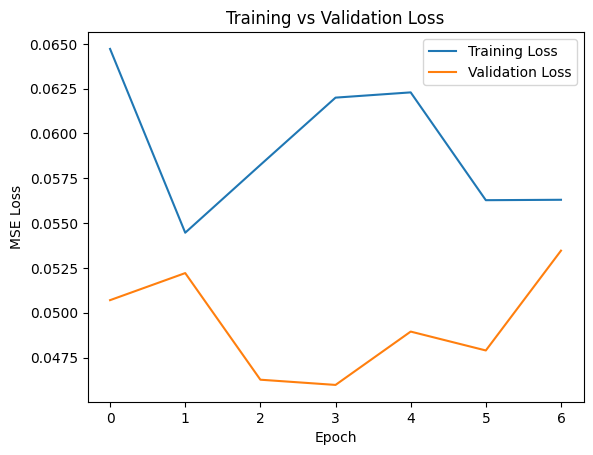

In [20]:
# ----------------------------
# Train / Validation Split
# ----------------------------
from sklearn.model_selection import train_test_split
import os

# Ensure the dataframe has a steering column; if not, create one with zeros
if 'steering' not in df.columns:
    df['steering'] = 0.0

# Split the dataset into training and validation (80/20 split)
train_samples, validation_samples = train_test_split(df, test_size=0.2, random_state=42)
print("Train samples:", len(train_samples), "Validation samples:", len(validation_samples))

# ----------------------------
# Training Configuration
# ----------------------------
BATCH_SIZE = 32
EPOCHS = 15   # Increased epochs for better training (can be adjusted)

# Create generators for training and validation
train_gen = generator(train_samples, batch_size=BATCH_SIZE, is_training=True)
valid_gen = generator(validation_samples, batch_size=BATCH_SIZE, is_training=False)

try:
    import tensorflow as tf
    from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

    # Build NVIDIA model
    model = build_nvidia_model()

    # Compile the model using Adam optimizer and Mean Squared Error (MSE) loss
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse')

    # Calculate steps per epoch (how many batches per epoch)
    steps_per_epoch = max(1, len(train_samples) // BATCH_SIZE)
    validation_steps = max(1, len(validation_samples) // BATCH_SIZE)

    # ----------------------------
    # Callbacks for better training
    # ----------------------------
    # Save only the model with the best validation loss
    checkpoint = ModelCheckpoint('model_best.h5',
                                monitor='val_loss',
                                save_best_only=True,
                                verbose=1)

    # Stop training early if validation loss does not improve for 3 epochs
    early_stop = EarlyStopping(monitor='val_loss',
                               patience=3,
                               restore_best_weights=True,
                               verbose=1)

    print("🚀 Starting training... Steps per epoch:", steps_per_epoch)

    # ----------------------------
    # Train the model
    # ----------------------------
    history = model.fit(train_gen,
                        steps_per_epoch=steps_per_epoch,
                        validation_data=valid_gen,
                        validation_steps=validation_steps,
                        epochs=EPOCHS,
                        verbose=1,
                        callbacks=[checkpoint, early_stop])

    # ----------------------------
    # Save the final trained model
    # ----------------------------
    model_path = os.path.join(DATA_DIR, 'model_final.h5')
    model.save(model_path)
    print("Model training complete. Saved final model to:", model_path)

    # ----------------------------
    # Plot training and validation loss curves
    # ----------------------------
    import matplotlib.pyplot as plt
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training vs Validation Loss')
    plt.show()

except Exception as e:
    print("Training skipped (TensorFlow not available or other error):", e)



## ⚙️ How to run this notebook locally (step-by-step)

1. Create & activate your virtual environment:
- **Linux / Mac**
```bash
python3 -m venv venv
source venv/bin/activate
```
- **Windows (PowerShell)**
```powershell
python -m venv venv
.
env\Scripts\Activate.ps1
```

2. Install requirements:
```bash
pip install -r /mnt/data/requirements.txt
```

3. Start Jupyter and open the notebook:
```bash
jupyter notebook /mnt/data/self_driving_starter.ipynb
```

4. Run cells top-to-bottom. 
